In [ ]:
!pip install -U qiskit

In [ ]:
import qiskit
print(qiskit.__version__)


2.1.0


In [ ]:
!pip install -U qiskit_aer

In [ ]:
!pip install -U qiskit_ibm_runtime

In [ ]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)

0.40.1


In [ ]:
!pip install -U pylatexenc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2
from qiskit.quantum_info import Pauli, SparsePauliOp, hellinger_fidelity

In [ ]:
from qiskit_aer.primitives import Sampler, Estimator as EstimatorV1

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeTorino

In [ ]:
from qiskit.result.utils import marginal_distribution

In [ ]:
#!pip install -U qiskit-ibm-provider
#from qiskit_ibm_provider import IBMProvider


In [ ]:
'''from qiskit.providers.fake_provider import FakeBelem
from qiskit_aer.noise import NoiseModel

# Load a fake backend
fake_backend = FakeBelem()

# Generate the noise model from the fake backend
noise_model = NoiseModel.from_backend(fake_backend)'''

In [ ]:
#!pip install --upgrade qiskit


In [ ]:
# implementing time simulation using trotterisation
# Psi(t)= U(t)Psi(0), U(t) is the time evolution operator
# U(t)= e^(-iHt)
# time evolution is implemented by a series of dt time evolutions(linear trotterisation)
# trotterisation is required because Hamiltonian is a summation of non-commuting operators

# Hamiltonian(H)= J*(XX+YY+ZZ), for two-spin Heisenberg model(isotropic)
# H= J*(summation(X_i X_j + Y_i Y_j + Z_i Z_j)) over [(i,j)=(0,1), (1,2)], for three-spin model
# each pair interacts with Heisenberg exchange — so 2-body interactions only between neighbors
# single entanglement in 2spin, chain entanglement in 3spin

In [ ]:
#parameters
t = 1.0          #total time
r = 10           #trotter steps (increase r for better accuracy)
dt = t / r       #small time step
J = 1

In [ ]:
#create two-spin hamiltonian
def two_spin_hamiltonian(dt):
    qc = QuantumCircuit(2)

    # XX interaction
    qc.h([0,1]) #to convert to Z basis
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)
    qc.h([0,1]) #reconvert to X basis

    # YY interaction
    qc.sdg(0) #Sadj gate to convert to X basis
    qc.h(0) #convert to Z basis
    qc.sdg(1)
    qc.h(1)
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)
    qc.h(0) #convert Z to X basis
    qc.s(0) #reconvert to Y basis
    qc.h(1)
    qc.s(1)

    # ZZ interaction
    #gate conjugation — the two CNOTs entangle the qubits such that the Z-rotation on the target becomes a ZZ rotation on the pair.
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)

    return qc


In [ ]:
def three_spin_hamiltonian(dt):
    qc = QuantumCircuit(3)

    for pair in [(0,1), (1,2)]: #on qubit 0-1 and 1-2
            i, j = pair

            # X_i X_j
            qc.h([i, j])
            qc.cx(i, j)
            qc.rz(-2 * J * dt, j)
            qc.cx(i, j)
            qc.h([i, j])

            # Y_i Y_j
            qc.sdg(i)
            qc.h(i)
            qc.sdg(j)
            qc.h(j)
            qc.cx(i, j)
            qc.rz(2 * dt, j)
            qc.cx(i, j)
            qc.h(i)
            qc.s(i)
            qc.h(j)
            qc.s(j)

            # Z_i Z_j
            qc.cx(i, j)
            qc.rz(-2 * J * dt, j)
            qc.cx(i, j)

    return qc


In [ ]:
#generate circuits at different times (record evolution of the state)
def two_spin_evolution_circuits(n_steps, dt):

    circuits = []
    for step in range(1, n_steps + 1):
        qc = QuantumCircuit(2)
        for _ in range(step):
            qc.compose(two_spin_hamiltonian(dt), inplace=True)
        qc.measure_all()
        circuits.append(qc)
    return circuits


In [ ]:
#generate circuits at different times along with pre inserted Z0 operator
def two_spin_correlation_circuits(n_steps, dt):
    circuits = []
    for step in range(1, n_steps + 1):
      #example state Psi00
        qc = QuantumCircuit(2)
        qc.h(0)
        qc.cx(0, 1)

        #insert Z0 observable at t=0
        qc.z(0)

        #apply U(t) evolution
        for _ in range(step):
            qc.compose(two_spin_hamiltonian(dt), inplace=True)

        #no need to measure yet — Estimator will apply Z1 observable
        circuits.append(qc)

    return circuits

In [ ]:
def three_spin_evolution_circuits(n_steps, dt):
    #generate circuits at different times
    circuits = []
    for step in range(1, n_steps + 1):
        qc = QuantumCircuit(3)
        for _ in range(step):
            qc.compose(three_spin_hamiltonian(dt), inplace=True)
        qc.measure_all()
        circuits.append(qc)
    return circuits


In [ ]:
def three_spin_correlation_circuits(n_steps, dt):
    circuits = []
    for step in range(1, n_steps + 1):
        qc = QuantumCircuit(3)
        qc.h(0)
        qc.cx(0, 1)

        qc.z(0)

        for _ in range(step):
            qc.compose(three_spin_hamiltonian(dt), inplace=True)

        circuits.append(qc)

    return circuits

In [ ]:
#circuit.measure_all() in Qiskit is a convenience method that adds measurements to all qubits in the circuit
#it maps each qubit to a corresponding classical bit

#count data is the raw output of your quantum simulation
#extract observables (like <Z1Z2> or <X1X2>) from these counts using postprocessing techniques

#dynamic correlation functions measure temporal correlations
#they measure how spin states are correlated across time steps, not just space (between qubits)


In [ ]:
#simulate with primitive estimator (local and ideal)

shots = 8192
simulator = AerSimulator()
estimator_ideal = EstimatorV1()


In [ ]:
from google.colab import userdata
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token= userdata.get('IBM_API_KEY')
)

available_backends = service.backends()
print("Available backends:")
for backend in available_backends:
    print(backend.name)

#noisy estimator (cloud computation)
backend= service.backend('ibm_brisbane')
session = Session(backend=backend)
estimator_noisy = EstimatorV2(session)

/tmp/ipython-input-20-1415172881.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


Available backends:
ibm_brisbane
ibm_sherbrooke


In [ ]:
sampler_ideal = Sampler()
sampler_noisy = Sampler()

In [ ]:
def normalize(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

In [ ]:
def hellinger(p, q):
    # Get the union of keys from both dictionaries
    all_keys = set(p.keys()).union(set(q.keys()))
    sqrt_sum = 0
    for k in all_keys:
        # Get the probability for key k from p, default to 0 if key not found
        p_k = p.get(k, 0)
        # Get the probability for key k from q, default to 0 if key not found
        q_k = q.get(k, 0)
        sqrt_sum += np.sqrt(p_k * q_k)
    return sqrt_sum ** 2

In [ ]:
#observables
Z0 = SparsePauliOp.from_list([("ZI", 1)])  #Z on qubit 0
Z1 = SparsePauliOp.from_list([("IZ", 1)])  #Z on qubit 1
ZZ = SparsePauliOp.from_list([("ZZ", 1)])  #Z tensored Z

#these observables alone don't give full time-dependent correlation functions like <Z0(0)Z1(t)>
#for that, would have to insert Z0 before time evolution and measure Z1 after, or simulate the Heisenberg-picture observable.

exp_Z0, exp_Z1, exp_ZZ = [], [], [] #expectation values of the observables (ideal simulation)
circuits_2spin = two_spin_evolution_circuits(r, dt)
observables = [Z0, Z1, ZZ]
fidelity_vals_2spin=[]



for qc in circuits_2spin:
    job = estimator_ideal.run([qc]*len(observables), observables)
    result = job.result().values
    exp_Z0.append(result[0])
    exp_Z1.append(result[1])
    exp_ZZ.append(result[2])

    job_ideal = sampler_ideal.run([qc])
    ideal_result = job_ideal.result()
    ideal_probs = dict(ideal_result.quasi_dists[0])  #this is a QuasiDistribution

    job_noisy = sampler_noisy.run([qc], backend= FakeTorino)
    noisy_result = job_noisy.result()
    noisy_probs = dict(noisy_result.quasi_dists[0])

    fidelity = hellinger(ideal_probs, noisy_probs)
    fidelity_vals_2spin.append(fidelity)




In [ ]:
#dynamic correlation circuits
two_spin_corr_circuits = two_spin_correlation_circuits(r, dt)
two_spin_corr_Z0Z1, two_spin_corr_Z0Z1_noisy = [], []
noisy_observable = SparsePauliOp.from_list([("IZ", 1)])


for qc in two_spin_corr_circuits:
    job1 = estimator_ideal.run([qc], [SparsePauliOp.from_list([("IZ", 1)])])
    result1 = job1.result()
    values1= result1.values
    two_spin_corr_Z0Z1.append(values1[0])

    #transpiled_qc = transpile(qc, backend=backend)

    job2 = estimator_ideal.run([qc], [SparsePauliOp.from_list([("IZ", 1)])], backend= FakeTorino)
    result2 = job2.result()
    values2= result2.values
    two_spin_corr_Z0Z1_noisy.append(values2[0])



In [ ]:
'''ideal_state = Statevector.from_instruction(qc)

    noisy_sim = AerSimulator(noise_model=noise_model, method="statevector")
    qc_trans = transpile(qc, backend=noisy_sim)
    result = noisy_sim.run(qc_trans).result()
    noisy_state = result.get_statevector()

    fid = state_fidelity(ideal_state, noisy_state)
    fidelity_vals_2spin.append(fid)'''

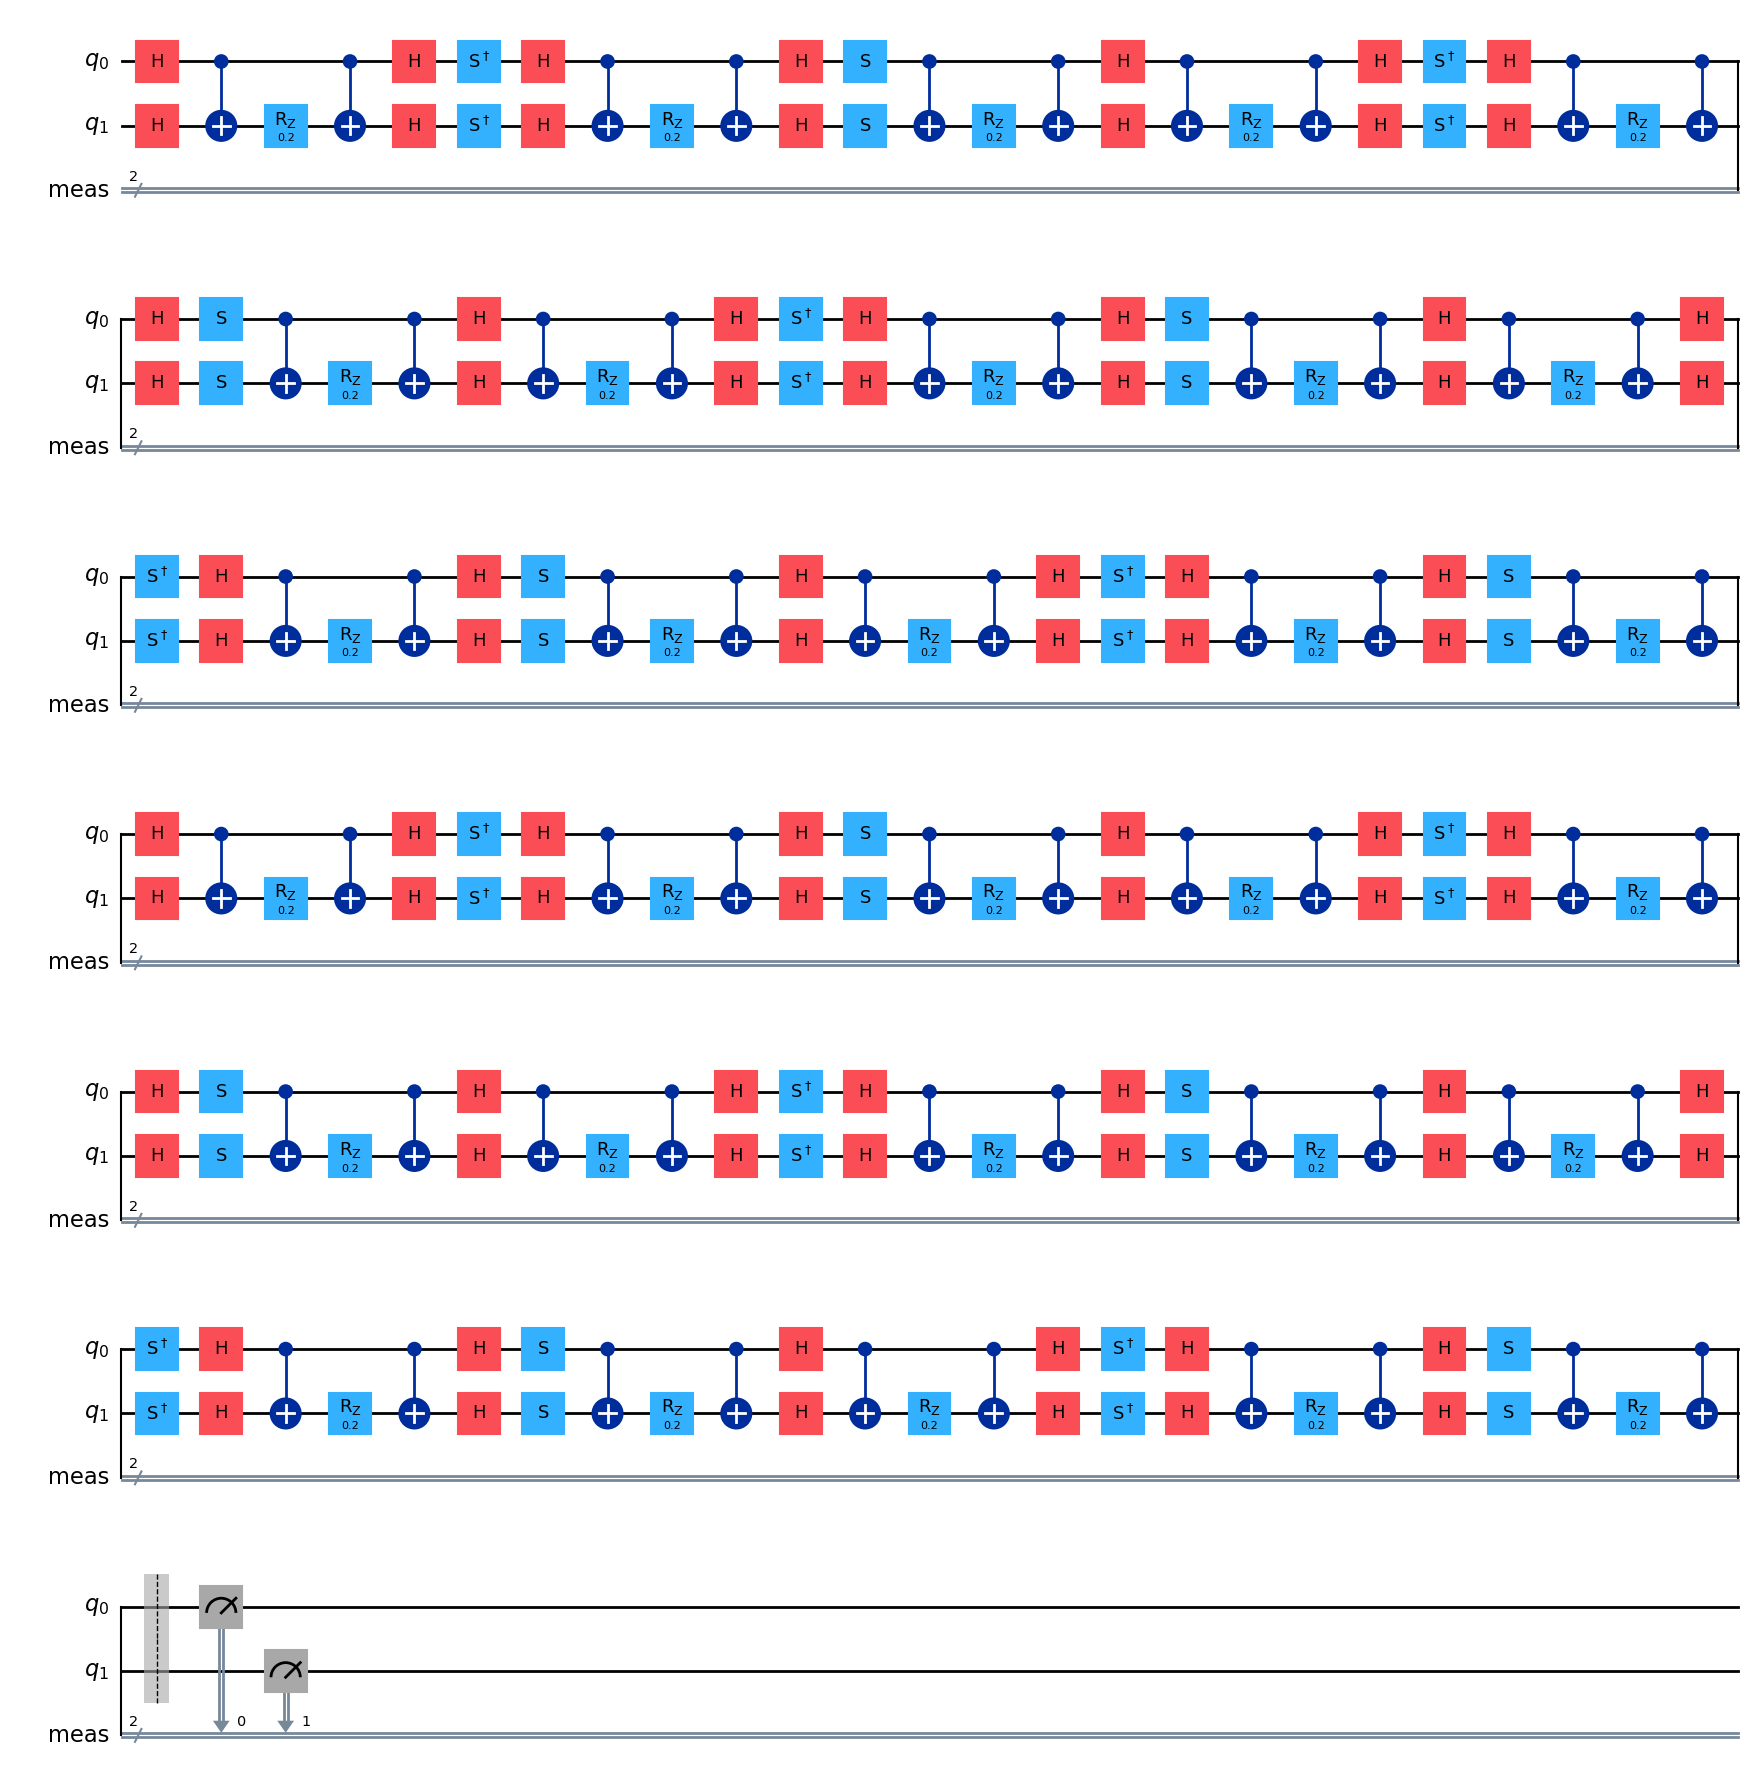

In [ ]:
evolution_circuit_2spin= circuits_2spin[-1]
evolution_circuit_2spin.draw('mpl')

ValueError: x and y must have same first dimension, but have shapes (256,) and (10,)

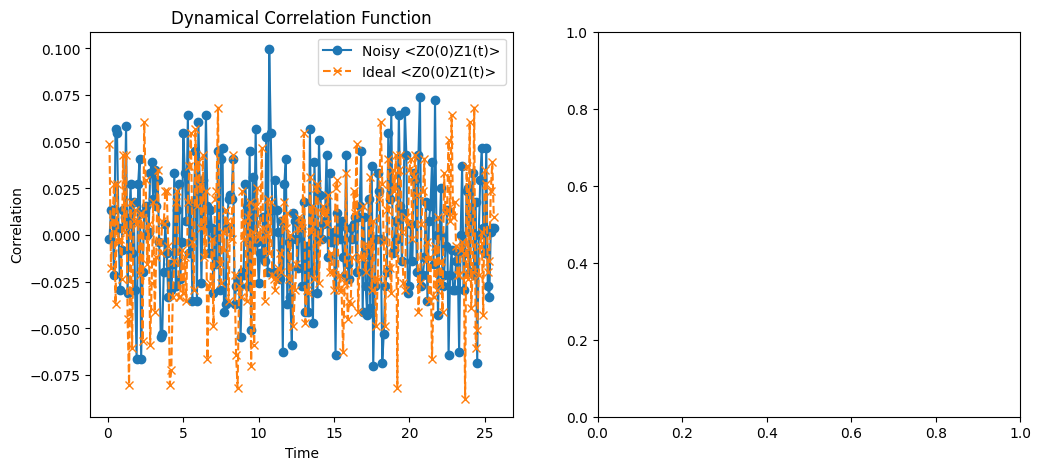

In [ ]:
#to compare ideal and noisy simulations (study hardware induced errors)
time_points = [dt * i for i in range(1, r + 1)]

plt.figure(figsize=(12, 5))

#plot correlation function
plt.subplot(1, 2, 1)
plt.plot(time_points, two_spin_corr_Z0Z1_noisy, label="Noisy <Z0(0)Z1(t)>", marker="o")
plt.plot(time_points, two_spin_corr_Z0Z1, label="Ideal <Z0(0)Z1(t)>", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("Dynamical Correlation Function")
plt.legend()

# Plot fidelity
plt.subplot(1, 2, 2)
plt.plot(time_points, fidelity_vals_2spin, label="Fidelity for two spin Heisenberg model", color="green", marker="s")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Time")
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#observables (3-qubit)
Z0 = SparsePauliOp.from_list([("ZII", 1)])
Z1 = SparsePauliOp.from_list([("IZI", 1)])
Z2 = SparsePauliOp.from_list([("IIZ", 1)])
Z0Z1 = SparsePauliOp.from_list([("ZZI", 1)])
Z1Z2 = SparsePauliOp.from_list([("IZZ", 1)])
Z0Z2 = SparsePauliOp.from_list([("ZIZ", 1)])

circuits_3spin = three_spin_evolution_circuits(r, dt)

exp_Z0, exp_Z1, exp_Z2 = [], [], []
exp_Z0Z1, exp_Z1Z2, exp_Z0Z2 = [], [], []
observables = [Z0, Z1, Z2, Z0Z1, Z1Z2, Z0Z2]
fidelity_vals_3spin = []

#measure observables at each time step
for qc in circuits_3spin:
    job = estimator_ideal.run([qc]*len(observables), observables)
    result = job.result().values
    exp_Z0.append(result[0])
    exp_Z1.append(result[1])
    exp_Z2.append(result[2])
    exp_Z0Z1.append(result[3])
    exp_Z1Z2.append(result[4])
    exp_Z0Z2.append(result[5])

    job_ideal = sampler_ideal.run([qc])
    ideal_result = job_ideal.result()
    ideal_probs = dict(ideal_result.quasi_dists[0])  #this is a QuasiDistribution

    job_noisy = sampler_noisy.run([qc], backend= FakeTorino)
    noisy_result = job_noisy.result()
    noisy_probs = dict(noisy_result.quasi_dists[0])

    fidelity = hellinger(ideal_probs, noisy_probs)
    fidelity_vals_3spin.append(fidelity)



In [ ]:
#dynamic correlation circuits
three_spin_corr_circuits = three_spin_correlation_circuits(r, dt)
three_spin_corr_Z0Z2, three_spin_corr_Z0Z2_noisy = [], []


for qc in three_spin_corr_circuits:
    job1 = estimator_ideal.run([qc],[Z2])  #only Z2 measured at t
    result1 = job1.result()
    values1= result1.values
    three_spin_corr_Z0Z2.append(values1[0])

    job2 = estimator_ideal.run([qc], [Z2], backend=FakeTorino)
    result2 = job2.result()
    values2= result2.values
    three_spin_corr_Z0Z2_noisy.append(values2[0])


In [ ]:
    '''ideal_state = Statevector.from_instruction(qc)

    noisy_sim = AerSimulator(noise_model=noise_model, method="statevector")
    qc_trans = transpile(qc, backend=noisy_sim)
    result = noisy_sim.run(qc_trans).result()
    noisy_state = result.get_statevector()

    fid = state_fidelity(ideal_state, noisy_state)'''

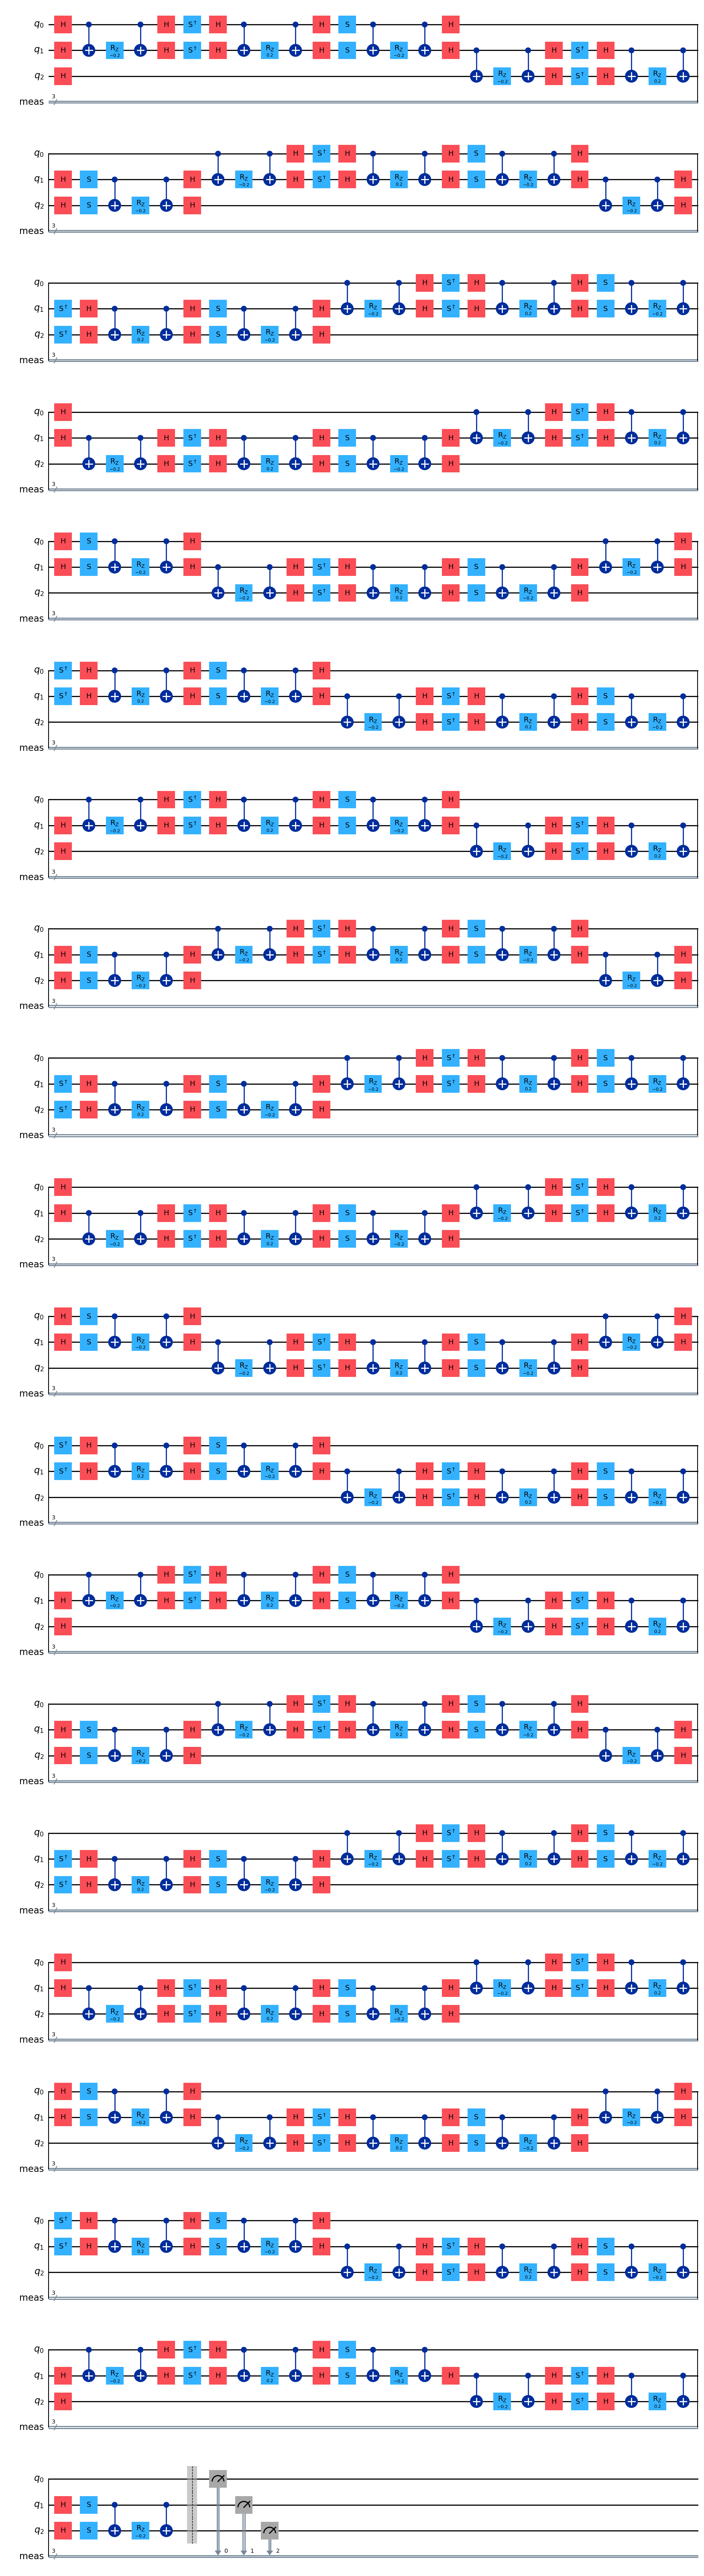

In [ ]:
evolution_circuit_3spin= circuits_3spin[-1]
evolution_circuit_3spin.draw('mpl')

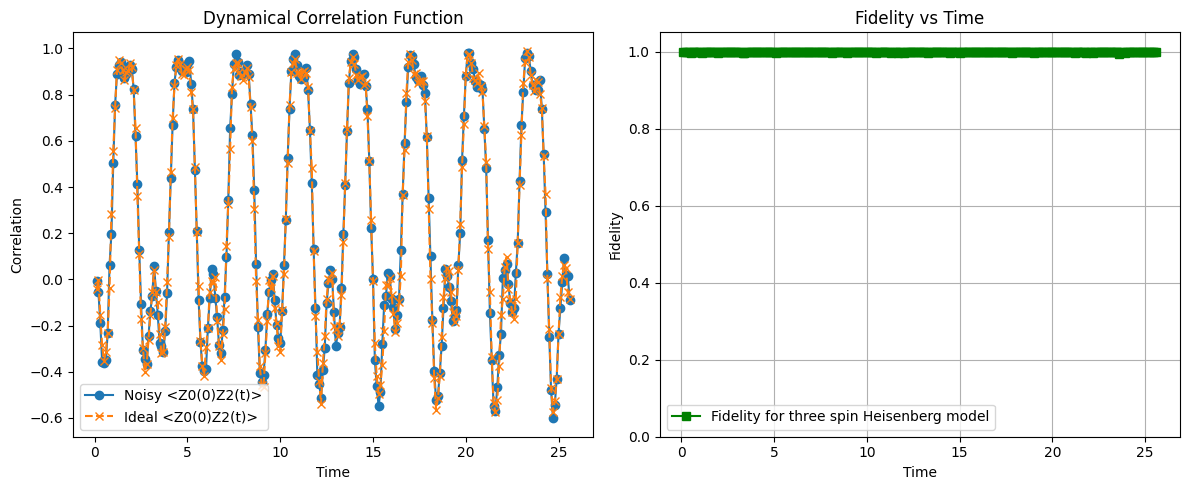

In [ ]:
#to compare ideal and noisy simulations (study hardware induced errors)
time_points = [dt * i for i in range(1, r + 1)]

plt.figure(figsize=(12, 5))

#plot correlation function
plt.subplot(1, 2, 1)
plt.plot(time_points, three_spin_corr_Z0Z2_noisy, label="Noisy <Z0(0)Z2(t)>", marker="o")
plt.plot(time_points, three_spin_corr_Z0Z2, label="Ideal <Z0(0)Z2(t)>", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("Dynamical Correlation Function")
plt.legend()

# Plot fidelity
plt.subplot(1, 2, 2)
plt.plot(time_points, fidelity_vals_3spin, label="Fidelity for three spin Heisenberg model", color="green", marker="s")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Time")
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#HARDWARE INDUCED ERRORS

#come from real hardware noise or simulation of noise (via QASM with noise model or runtime with estimatorV2)

#types -
#gate errors: imperfect single-/two-qubit gate operations
#decoherence: qubits lose information via T₁ (relaxation) and T₂ (dephasing)
#readout errors: measurement errors
#crosstalk: gate operations on one qubit affect others

#these errors are stochastic and non-unitary, and are amplified with circuit depth (i.e., number of Trotter steps)

In [ ]:
#TROTTERISATION ERROR

#ideally Hamiltonian is continuous but to digitally simulate we break hamiltonian into X,Y,Z components
#these are non-commutative
#to simulate evolution we need to do discretisation, break time into r steps
#This approximation introduces a systematic error that vanishes as delta t tends to 0
#but this error accumulates with time on keeping the number of steps fixed
#this error is coherent, unitary and deterministic
#controlled by r (time-steps)


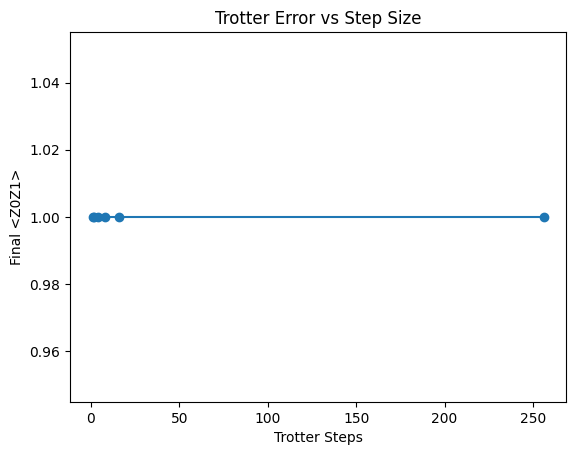

In [ ]:
steps_list = [1, 2, 4, 8, 16, 256]
observable_vals = [] #observable used- ZZ

for r in steps_list:
    circuits = two_spin_evolution_circuits(r, t/ r)
    obs_vals_r = []
    for qc in circuits:
        result = estimator_ideal.run([qc], [ZZ]).result().values
        obs_vals_r.append(result[0])
    observable_vals.append(obs_vals_r[-1])  # final time value

plt.plot(steps_list, observable_vals, marker="o")
plt.xlabel("Trotter Steps")
plt.ylabel("Final <Z0Z1>")
plt.title("Trotter Error vs Step Size")
plt.show()
